# Trabalho Final

In [1]:
from __future__ import print_function

In [2]:
#Util
import operator
import math
import random
import numpy as np
from numpy import linspace,sin,pi,int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Audio
import librosa
import librosa.display
import thinkdsp
import thinkplot

A manipulação  sonora será feita utilizando o **thinkDSP** e a obtenção das features para comparação através do librosa

In [3]:
# DADOS INICIAIS
wave = thinkdsp.read_wave('sounds/92002__jcveliz__violin-origional.wav')
target = wave.segment(1.18995, 0.62)

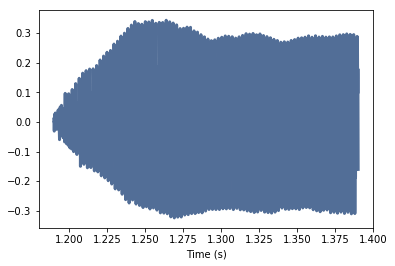

In [4]:
# Segmento objetivo. Obtido por tentativa e erro
target = wave.segment(1.18995, 0.2)
target.plot()
thinkplot.config(xlabel='Time (s)')
target.make_audio()


In [5]:
t = linspace(0,target.duration,target.duration*target.framerate)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [6]:
target.make_spectrum().peaks()[1][1]

440.0

Função utilizada para calcular o MFCC

In [7]:
def getMFCC(y, sr, n_mfcc):
    ### MFC ###
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.logamplitude(S, ref_power=np.max)

    ### MFCC ###

    # Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)

    return mfcc

Função utilizada para calcular a diferença de MFCC

In [8]:
def squared_error(target, generated):
    erro = target - generated
    squared_error = erro ** 2
    return np.sum(squared_error)

In [9]:
def mag_pha_s_error(target, generated):
    partitions = 11
    # obtendo os parametros
    target_spectrum = target.make_spectrum()
    target_pha = target_spectrum.angles
    target_mag = np.absolute(target_spectrum.hs)
    generated_spectrum = generated.make_spectrum()
    generated_pha = generated_spectrum.angles
    generated_mag = np.absolute(generated_spectrum.hs)
    
    # dividindo em bandas(partitions)
    target_pha_bin    = np.array(np.array_split(target_pha,partitions,axis=0))
    generated_pha_bin = np.array(np.array_split(generated_pha,partitions,axis=0))
    target_mag_bin    = np.array(np.array_split(target_mag,partitions,axis=0))
    generated_mag_bin = np.array(np.array_split(generated_mag,partitions,axis=0))
    
    pha_error = ((target_pha_bin - generated_pha_bin)**2).mean(axis=1)
    mag_error = ((target_mag_bin - generated_mag_bin)**2).mean(axis=1)
    
    pha_error_norm = pha_error/pha_error.max()
    mag_error_norm = mag_error/mag_error.max()
    
    pha_sme = pha_error_norm.mean()
    mag_sme = mag_error_norm.mean()
    
    return (pha_sme + mag_sme)/2
    

In [10]:
def mag_fre_s_error(target, generated):
    target_peaks = np.array(target.make_spectrum().peaks())
    generated_peaks = np.array(generated.make_spectrum().peaks())
    mag_sme,fre_sme=((target_peaks - generated_peaks)**2).mean(axis=0)
    
    return mag_sme, fre_sme

In [11]:
f = target.make_spectrum().peaks()[1][1]

A seguir iremos realizar as configurações para executar a Programação Genética com **DEAP**

In [12]:
# Define new functions

pset = gp.PrimitiveSet("MAIN", 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(math.sin, 1)
pset.addTerminal(2*pi)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.addEphemeralConstant("rand", lambda: random.randint(100, 1000))
pset.renameArguments(ARG0='t')
pset.renameArguments(ARG1='f')

In [13]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#import multiprocessing

toolbox = base.Toolbox()
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [14]:
# Funcao para calculo de fitness
def evalSymbReg(individual, target):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    gen_ys = np.array([func(x,f) for x in t])
    gen_sr = target.framerate
    generated = thinkdsp.Wave(ys=gen_ys,framerate=gen_sr)

    #gen_mfcc = getMFCC(gen_ys, gen_sr, False)
    #target_mfcc = getMFCC(target.ys, target.framerate, False)
    #result = mfcc_squared_error(gen_mfcc,target_mfcc)
    #result = mfcc_squared_error(gen_ys,target.ys)
    result = mag_pha_s_error(target,generated)
    return result,

In [15]:
toolbox.register("evaluate", evalSymbReg, target=target)
# toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=4)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

Com tudo configurado agora é possivel criar a função que irá realizar a execução do algoritmo

In [22]:
def main():
    random.seed(random.randint(1,100))

    pop = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)

    # CXPB  - Probabilidade de crossover
    # MUTPB - Probabilidade de mutação
    # NGEN  - Numero de gerações
    CXPB, MUTPB, NGEN = 0.75, 0.12, 50

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, NGEN, stats=mstats,halloffame=hof, verbose=True)
    #pop, log = algorithms.eaMuCommaLambda(population=pop, 
    #                                      toolbox=toolbox, 
    #                                      mu=200, 
    #                                      lambda_=200, 
    #                                      cxpb=CXPB, 
    #                                      mutpb=MUTPB, 
    #                                      ngen=NGEN, 
    #                                      stats=mstats,
    #                                      halloffame=hof, 
    #                                      verbose=True)
    # pop, log = gp.harm(pop, toolbox, 0.5, 0.1, 40, alpha=0.05, beta=10, gamma=0.25, rho=0.9, stats=mstats,
    #                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

In [23]:
pop, log, hof = main()

   	      	                         fitness                         	              size             
   	      	---------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std      	avg  	max	min	std    
0  	1000  	0.401438	0.507182	0.250281	0.0737184	3.616	7  	2  	1.51147
1  	771   	0.32292 	0.757224	0.250281	0.0836245	4.342	29 	1  	3.13768
2  	788   	0.280973	0.507182	0.204741	0.0663821	4.796	37 	1  	3.93604
3  	758   	0.276526	0.77525 	0.164171	0.0647169	5.154	34 	1  	4.32877
4  	776   	0.278376	0.812488	0.164171	0.0728515	6.437	40 	1  	5.95886
5  	780   	0.283941	0.824461	0.154097	0.0958463	9.012	58 	1  	8.02371
6  	777   	0.30254 	0.828136	0.154097	0.138093 	13.671	41 	1  	8.04616
7  	792   	0.292545	0.830437	0.152403	0.156369 	16.215	47 	1  	7.11581
8  	794   	0.306974	0.836659	0.132802	0.172052 	18.127	52 	2  	7.78748
9  	775   	0.288928	0.831118	0.132802	0.165092 	20.275	56 	1  	7.73495
10 	761   	0.293961	0.83

Agora é possível realizar a comparação das ondas

In [18]:
target.make_audio()

add(sin(mul(mul(sin(1), 739), t)), mul(sin(mul(mul(t, 739), 739)), mul(mul(t, mul(add(mul(sin(sin(t)), -1), mul(t, 6.283185307179586)), sin(add(sin(mul(mul(sin(t), sin(358)), mul(sin(6.283185307179586), mul(652, 470)))), f)))), 739)))


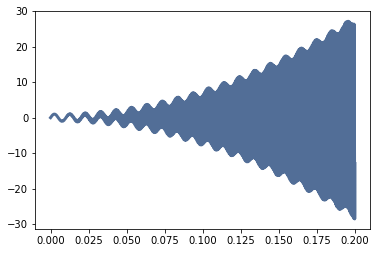

In [19]:
function = gp.compile(hof[0],pset)
gen_ys = np.array([function(x,f) for x in t])
gen_sr = target.framerate
generated = thinkdsp.Wave(ys=gen_ys,framerate=gen_sr)
generated.plot()
print(str(hof[0]))
generated.make_audio()


# MELHORES EQUACOES ENCONTRADAS  
- mul(add(x, x), sin(mul(3.141592653589793, sin(mul(3.141592653589793, sin(mul(2453.6376519837113, x)))))))  
- mul(add(mul(sin(t), mul(mul(t, mul(-841, 3.141592653589793)), 3.141592653589793)), 980), sin(mul(3.141592653589793, add(mul(35, add(add(mul(t, mul(-841, 3.141592653589793)), mul(t, 3.141592653589793)), mul(t, 3.141592653589793))), mul(3.141592653589793, 35)))))  
- sin(mul(mul(29, -1), add(mul(t, f), mul(mul(29, -1), t))))
- sin(add(mul(mul(12, f), add(add(sin(add(add(sin(12), t), 12)), t), t)), add(f, 3.141592653589793)))  
- add(sin(mul(mul(sin(1), 739), t)), mul(sin(mul(mul(t, 739), 739)), mul(mul(t, mul(add(mul(sin(sin(t)), -1), mul(t, 6.283185307179586)), sin(add(sin(mul(mul(sin(t), sin(358)), mul(sin(6.283185307179586), mul(652, 470)))), f)))), 739)))

In [20]:
def plot_log(logbook,title):
    """Funcao auxiliar para plotar gráfico"""
    gen = logbook.select("gen")
    min = logbook.chapters["fitness"].select("min")
    avg = logbook.chapters["fitness"].select("avg")
    max = logbook.chapters["fitness"].select("max")
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Geração")
    ax1.set_ylabel("Fitness", color="b")
    
    line1 = ax1.plot(gen, min, "b-", label="Mínimo")
    line2 = ax1.plot(gen, avg, "g-", label="Médio")
    line3 = ax1.plot(gen, max, "y-", label="Máximo")

    lns = line3 + line2 + line1
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=4)
    
    fig.set_size_inches(15, 5, forward=True)

    plt.show()

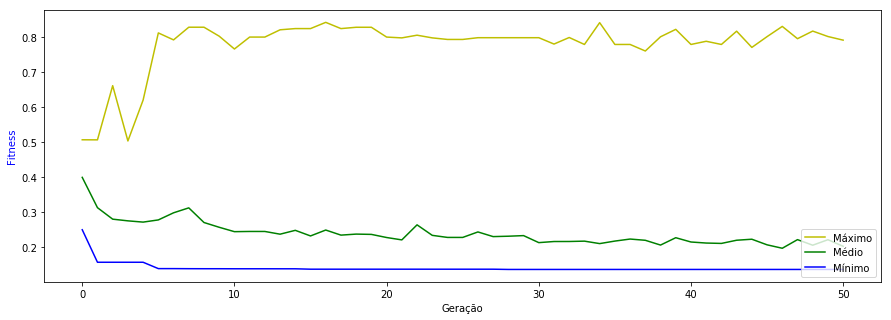

In [21]:
plot_log(log,'aaa')